In [45]:
import cv2 
import glob  
import numpy as np
import imutils
import csv 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from IPython.display import Image, display 
%matplotlib inline


In [46]:

class ColorDescriptor:
	def __init__(self, bins):
		# store the number of bins for the 3D histogram
		self.bins = bins

	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		features = []

		# grab the dimensions and compute the center of the image
		(h, w) = image.shape[:2]
		(cX, cY) = (int(w * 0.5), int(h * 0.5))

		# divide the image into four rectangles/segments (top-left,
		# top-right, bottom-right, bottom-left)
		segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
			(0, cX, cY, h)]

		# construct an elliptical mask representing the center of the
		# image
		(axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
		ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
		cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

		# loop over the segments
		for (startX, endX, startY, endY) in segments:
			# construct a mask for each corner of the image, subtracting
			# the elliptical center from it
			cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
			cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
			cornerMask = cv2.subtract(cornerMask, ellipMask)

			# extract a color histogram from the image, then update the
			# feature vector
			hist = self.histogram(image, cornerMask)
			features.extend(hist)

		# extract a color histogram from the elliptical region and
		# update the feature vector
		hist = self.histogram(image, ellipMask)
		features.extend(hist)

		# return the feature vector
		return features

	def histogram(self, image, mask):
		# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
		hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
			[0, 180, 0, 256, 0, 256])

		# normalize the histogram if we are using OpenCV 2.4
		if imutils.is_cv2():
			hist = cv2.normalize(hist).flatten()

		# otherwise handle for OpenCV 3+
		else:
			hist = cv2.normalize(hist, hist).flatten()

		# return the histogram
		return hist

In [47]:

class Searcher:
	def __init__(self, indexPath):
		# store our index path
		self.indexPath = indexPath

	def search(self, queryFeatures, limit = 10):
		# initialize our dictionary of results
		results = {}
		count_image_search = 1
		# open the index file for reading
		with open(self.indexPath) as f:
			# initialize the CSV reader
			reader = csv.reader(f)

			# loop over the rows in the index
			for row in reader:
				print("searching file ........ . checking file number ", count_image_search, " . ")
				# parse out the image ID and features, then compute the
				# chi-squared distance between the features in our index
				# and our query features
				features = [float(x) for x in row[1:]]
				d = self.chi2_distance(features, queryFeatures)

				# now that we have the distance between the two feature
				# vectors, we can udpate the results dictionary -- the
				# key is the current image ID in the index and the
				# value is the distance we just computed, representing
				# how 'similar' the image in the index is to our query
				results[row[0]] = d
				count_image_search = count_image_search + 1
			# close the reader
			f.close()

		# sort our results, so that the smaller distances (i.e. the
		# more relevant images are at the front of the list)
		results = sorted([(v, k) for (k, v) in results.items()])

		# return our (limited) results
		return results[:limit]

	def chi2_distance(self, histA, histB, eps = 1e-10):
		# compute the chi-squared distance
		d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
			for (a, b) in zip(histA, histB)])

		# return the chi-squared distance
		return d

In [48]:
root_path = '../../data/vacation_image_search_engine_data/'

# input parameter 

In [49]:
directory_path_of_image_files_to_be_indexed = input("Path to the directory that contains the images to be indexed. click 'ENTER' key for default value . ") or (root_path + "dataset")


Path to the directory that contains the images to be indexed. click 'ENTER' key for default value . 


In [50]:
path_of_index_file_to_store = input("Path to where the computed index will be stored. click 'ENTER' key for default value . ") or "index.csv"


Path to where the computed index will be stored. click 'ENTER' key for default value . 


In [51]:
# initialize the color descriptor
cd = ColorDescriptor((8, 12, 3))


In [52]:
# open the output index file for writing
output = open(path_of_index_file_to_store, "w")


In [53]:

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(directory_path_of_image_files_to_be_indexed + "/*.png"):
	# extract the image ID (i.e. the unique filename) from the image
	# path and load the image itself
	imageID = imagePath[imagePath.rfind("/") + 1:]
	print("checking image at ", imageID, " to build index data . ")    
	image = cv2.imread(imagePath)

	# describe the image
	features = cd.describe(image)

	# write the features to file
	features = [str(f) for f in features]
	output.write("%s,%s\n" % ((root_path + imageID), ",".join(features)))

# close the index file
output.close()

checking image at  dataset\100000.png  to build index data . 
checking image at  dataset\100001.png  to build index data . 
checking image at  dataset\100002.png  to build index data . 
checking image at  dataset\100100.png  to build index data . 
checking image at  dataset\100101.png  to build index data . 
checking image at  dataset\100200.png  to build index data . 
checking image at  dataset\100201.png  to build index data . 
checking image at  dataset\100300.png  to build index data . 
checking image at  dataset\100301.png  to build index data . 
checking image at  dataset\100302.png  to build index data . 
checking image at  dataset\100400.png  to build index data . 
checking image at  dataset\100401.png  to build index data . 
checking image at  dataset\100500.png  to build index data . 
checking image at  dataset\100501.png  to build index data . 
checking image at  dataset\100502.png  to build index data . 
checking image at  dataset\100503.png  to build index data . 
checking

checking image at  dataset\105001.png  to build index data . 
checking image at  dataset\105002.png  to build index data . 
checking image at  dataset\105100.png  to build index data . 
checking image at  dataset\105101.png  to build index data . 
checking image at  dataset\105102.png  to build index data . 
checking image at  dataset\105103.png  to build index data . 
checking image at  dataset\105104.png  to build index data . 
checking image at  dataset\105200.png  to build index data . 
checking image at  dataset\105201.png  to build index data . 
checking image at  dataset\105300.png  to build index data . 
checking image at  dataset\105301.png  to build index data . 
checking image at  dataset\105400.png  to build index data . 
checking image at  dataset\105401.png  to build index data . 
checking image at  dataset\105500.png  to build index data . 
checking image at  dataset\105501.png  to build index data . 
checking image at  dataset\105600.png  to build index data . 
checking

checking image at  dataset\110302.png  to build index data . 
checking image at  dataset\110400.png  to build index data . 
checking image at  dataset\110401.png  to build index data . 
checking image at  dataset\110500.png  to build index data . 
checking image at  dataset\110501.png  to build index data . 
checking image at  dataset\110600.png  to build index data . 
checking image at  dataset\110601.png  to build index data . 
checking image at  dataset\110700.png  to build index data . 
checking image at  dataset\110701.png  to build index data . 
checking image at  dataset\110702.png  to build index data . 
checking image at  dataset\110800.png  to build index data . 
checking image at  dataset\110801.png  to build index data . 
checking image at  dataset\110802.png  to build index data . 
checking image at  dataset\110900.png  to build index data . 
checking image at  dataset\110901.png  to build index data . 
checking image at  dataset\111000.png  to build index data . 
checking

checking image at  dataset\116001.png  to build index data . 
checking image at  dataset\116002.png  to build index data . 
checking image at  dataset\116100.png  to build index data . 
checking image at  dataset\116101.png  to build index data . 
checking image at  dataset\116200.png  to build index data . 
checking image at  dataset\116201.png  to build index data . 
checking image at  dataset\116300.png  to build index data . 
checking image at  dataset\116301.png  to build index data . 
checking image at  dataset\116400.png  to build index data . 
checking image at  dataset\116401.png  to build index data . 
checking image at  dataset\116402.png  to build index data . 
checking image at  dataset\116500.png  to build index data . 
checking image at  dataset\116501.png  to build index data . 
checking image at  dataset\116600.png  to build index data . 
checking image at  dataset\116601.png  to build index data . 
checking image at  dataset\116700.png  to build index data . 
checking

checking image at  dataset\121201.png  to build index data . 
checking image at  dataset\121300.png  to build index data . 
checking image at  dataset\121301.png  to build index data . 
checking image at  dataset\121400.png  to build index data . 
checking image at  dataset\121401.png  to build index data . 
checking image at  dataset\121402.png  to build index data . 
checking image at  dataset\121403.png  to build index data . 
checking image at  dataset\121404.png  to build index data . 
checking image at  dataset\121500.png  to build index data . 
checking image at  dataset\121501.png  to build index data . 
checking image at  dataset\121600.png  to build index data . 
checking image at  dataset\121601.png  to build index data . 
checking image at  dataset\121700.png  to build index data . 
checking image at  dataset\121701.png  to build index data . 
checking image at  dataset\121800.png  to build index data . 
checking image at  dataset\121801.png  to build index data . 
checking

checking image at  dataset\126101.png  to build index data . 
checking image at  dataset\126102.png  to build index data . 
checking image at  dataset\126200.png  to build index data . 
checking image at  dataset\126201.png  to build index data . 
checking image at  dataset\126202.png  to build index data . 
checking image at  dataset\126300.png  to build index data . 
checking image at  dataset\126301.png  to build index data . 
checking image at  dataset\126400.png  to build index data . 
checking image at  dataset\126401.png  to build index data . 
checking image at  dataset\126402.png  to build index data . 
checking image at  dataset\126500.png  to build index data . 
checking image at  dataset\126501.png  to build index data . 
checking image at  dataset\126502.png  to build index data . 
checking image at  dataset\126600.png  to build index data . 
checking image at  dataset\126601.png  to build index data . 
checking image at  dataset\126700.png  to build index data . 
checking

# parameter input 

In [54]:
searcher_1 = input("Path to where the computed index will be stored. click 'ENTER' key for default value . ") or "index.csv"

Path to where the computed index will be stored. click 'ENTER' key for default value . 


In [55]:
query_1 = input("Path to the query image. click 'ENTER' key for default value . " ) or (root_path + "queries/108100.png")

Path to the query image. click 'ENTER' key for default value . 


In [56]:
type(query_1)

str

In [57]:
output_path_1  = input("Path to the result path. click 'ENTER' key for default value . ") or (root_path + "dataset")

Path to the result path. click 'ENTER' key for default value . 


In [58]:
# initialize the image descriptor
cd = ColorDescriptor((8, 12, 3))

# load the query image and describe it
query = cv2.imread(query_1)
features = cd.describe(query)

# perform the search 
searcher = Searcher(searcher_1)
results = searcher.search(features)

# display the query

cv2.imshow("Query", query)

    

i = 0
    
# loop over the results
for (score, resultID) in results:
	# load the result image and display it
	result = cv2.imread(resultID)
	cv2.imshow("Result", result)
	cv2.waitKey(0)

searching file ........ . checking file number  1  . 
searching file ........ . checking file number  2  . 
searching file ........ . checking file number  3  . 
searching file ........ . checking file number  4  . 
searching file ........ . checking file number  5  . 
searching file ........ . checking file number  6  . 
searching file ........ . checking file number  7  . 
searching file ........ . checking file number  8  . 
searching file ........ . checking file number  9  . 
searching file ........ . checking file number  10  . 
searching file ........ . checking file number  11  . 
searching file ........ . checking file number  12  . 
searching file ........ . checking file number  13  . 
searching file ........ . checking file number  14  . 
searching file ........ . checking file number  15  . 
searching file ........ . checking file number  16  . 
searching file ........ . checking file number  17  . 
searching file ........ . checking file number  18  . 
searching file ....

searching file ........ . checking file number  149  . 
searching file ........ . checking file number  150  . 
searching file ........ . checking file number  151  . 
searching file ........ . checking file number  152  . 
searching file ........ . checking file number  153  . 
searching file ........ . checking file number  154  . 
searching file ........ . checking file number  155  . 
searching file ........ . checking file number  156  . 
searching file ........ . checking file number  157  . 
searching file ........ . checking file number  158  . 
searching file ........ . checking file number  159  . 
searching file ........ . checking file number  160  . 
searching file ........ . checking file number  161  . 
searching file ........ . checking file number  162  . 
searching file ........ . checking file number  163  . 
searching file ........ . checking file number  164  . 
searching file ........ . checking file number  165  . 
searching file ........ . checking file number  

searching file ........ . checking file number  302  . 
searching file ........ . checking file number  303  . 
searching file ........ . checking file number  304  . 
searching file ........ . checking file number  305  . 
searching file ........ . checking file number  306  . 
searching file ........ . checking file number  307  . 
searching file ........ . checking file number  308  . 
searching file ........ . checking file number  309  . 
searching file ........ . checking file number  310  . 
searching file ........ . checking file number  311  . 
searching file ........ . checking file number  312  . 
searching file ........ . checking file number  313  . 
searching file ........ . checking file number  314  . 
searching file ........ . checking file number  315  . 
searching file ........ . checking file number  316  . 
searching file ........ . checking file number  317  . 
searching file ........ . checking file number  318  . 
searching file ........ . checking file number  

searching file ........ . checking file number  453  . 
searching file ........ . checking file number  454  . 
searching file ........ . checking file number  455  . 
searching file ........ . checking file number  456  . 
searching file ........ . checking file number  457  . 
searching file ........ . checking file number  458  . 
searching file ........ . checking file number  459  . 
searching file ........ . checking file number  460  . 
searching file ........ . checking file number  461  . 
searching file ........ . checking file number  462  . 
searching file ........ . checking file number  463  . 
searching file ........ . checking file number  464  . 
searching file ........ . checking file number  465  . 
searching file ........ . checking file number  466  . 
searching file ........ . checking file number  467  . 
searching file ........ . checking file number  468  . 
searching file ........ . checking file number  469  . 
searching file ........ . checking file number  

searching file ........ . checking file number  608  . 
searching file ........ . checking file number  609  . 
searching file ........ . checking file number  610  . 
searching file ........ . checking file number  611  . 
searching file ........ . checking file number  612  . 
searching file ........ . checking file number  613  . 
searching file ........ . checking file number  614  . 
searching file ........ . checking file number  615  . 
searching file ........ . checking file number  616  . 
searching file ........ . checking file number  617  . 
searching file ........ . checking file number  618  . 
searching file ........ . checking file number  619  . 
searching file ........ . checking file number  620  . 
searching file ........ . checking file number  621  . 
searching file ........ . checking file number  622  . 
searching file ........ . checking file number  623  . 
searching file ........ . checking file number  624  . 
searching file ........ . checking file number  

searching file ........ . checking file number  756  . 
searching file ........ . checking file number  757  . 
searching file ........ . checking file number  758  . 
searching file ........ . checking file number  759  . 
searching file ........ . checking file number  760  . 
searching file ........ . checking file number  761  . 
searching file ........ . checking file number  762  . 
searching file ........ . checking file number  763  . 
searching file ........ . checking file number  764  . 
searching file ........ . checking file number  765  . 
searching file ........ . checking file number  766  . 
searching file ........ . checking file number  767  . 
searching file ........ . checking file number  768  . 
searching file ........ . checking file number  769  . 
searching file ........ . checking file number  770  . 
searching file ........ . checking file number  771  . 
searching file ........ . checking file number  772  . 
searching file ........ . checking file number  

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                       IMAGE USED FOR QUERY :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



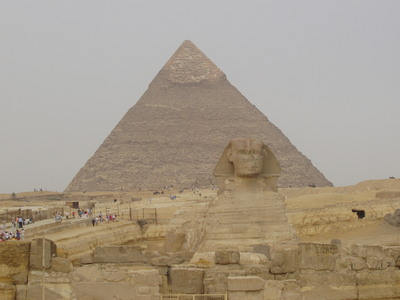


 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

                        SEARCH OUTPUT :   . 

  @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 


                  image output loading ... .



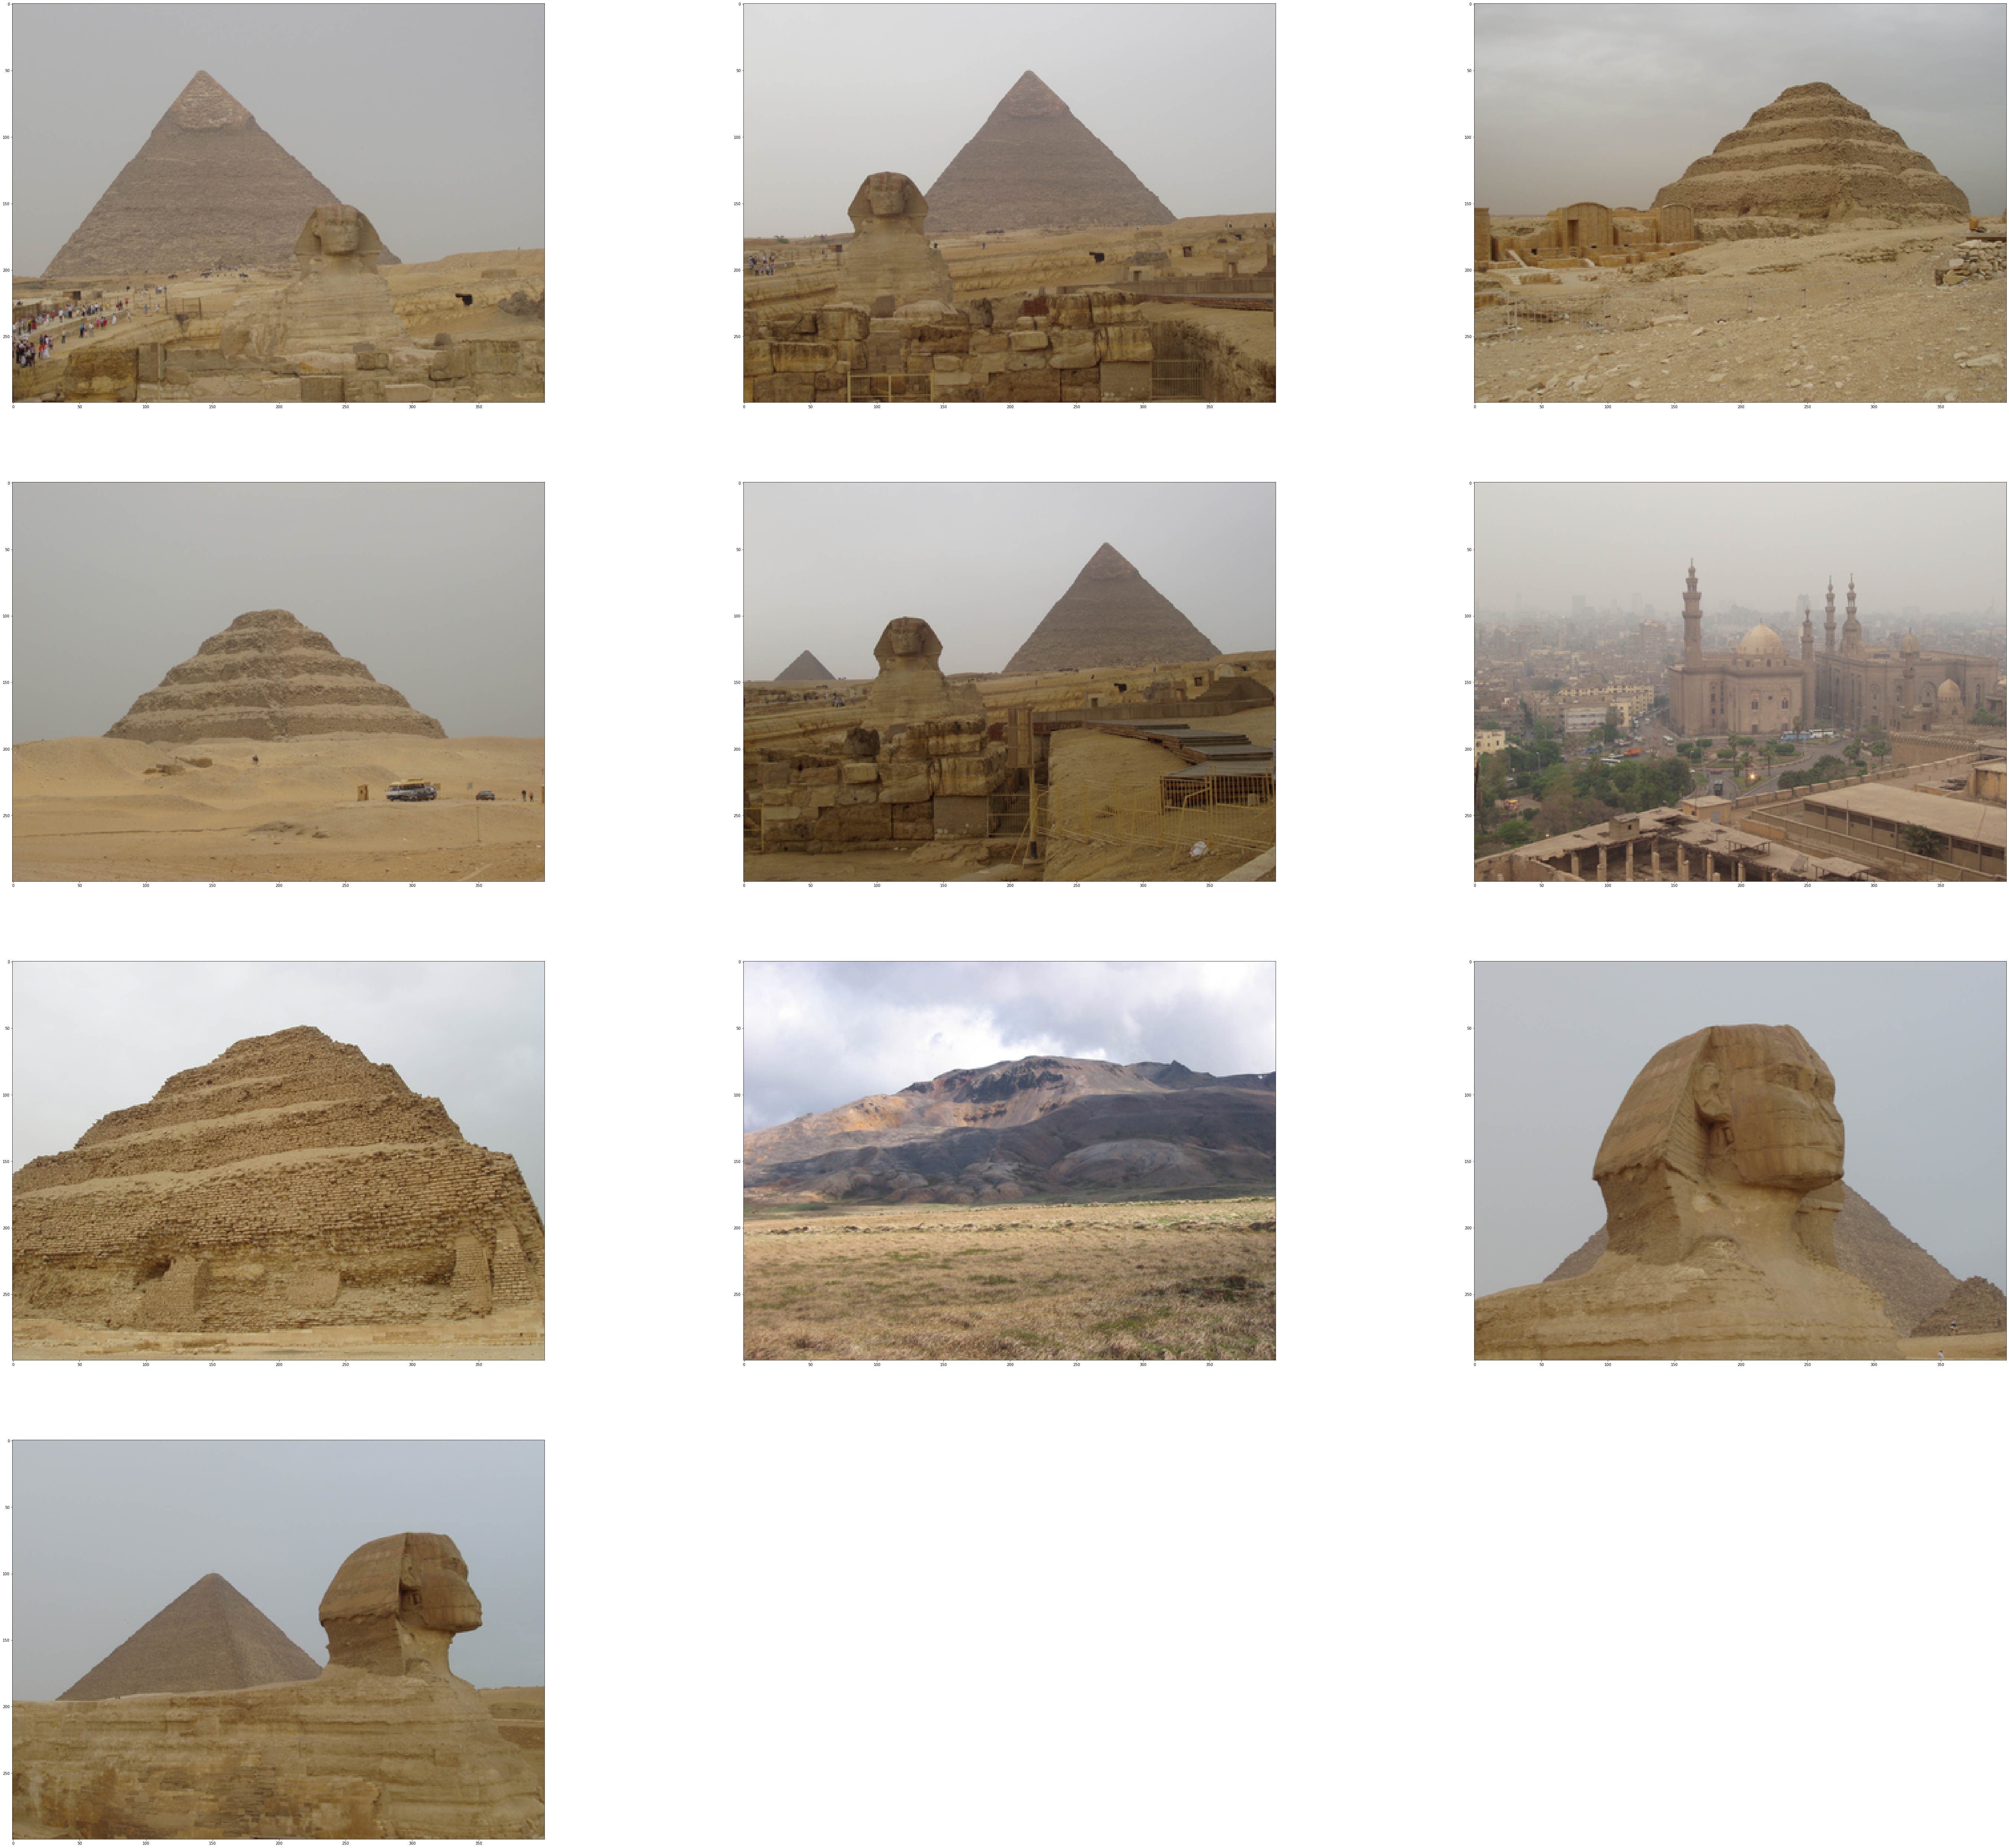


!!!!!!!!!!!!!!!!!!!!!   IMAGE SEARCH OUTPUT PRINTED   .   !!!!!!!!!!!!!!!!!!!!!!!!!!!



In [59]:

plt.figure(figsize=(100,91))
columns = 3

i = 0    

images = [] 

print(" ", 92*"@", "\n\n", "                      IMAGE USED FOR QUERY : ", " . \n\n ", 92*"@", "\n")
display(Image(filename=query_1))

print("\n", 91*"|","\n")


for (score, resultID) in results:
    images.append(mpimg.imread(resultID))

print(" ",92*"@", "\n\n", "                       SEARCH OUTPUT : ", " . \n\n ", 92*"@", "\n\n")   
print("                  image output loading ... .\n")

image_print_check = 0

for i, image in enumerate(images): 
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
        
plt.show()
    
print("\n!!!!!!!!!!!!!!!!!!!!!   IMAGE SEARCH OUTPUT PRINTED   .   !!!!!!!!!!!!!!!!!!!!!!!!!!!\n")    